In [70]:
from torch.utils.data import DataLoader, random_split
from collections import defaultdict
from tqdm import tqdm

import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import numpy as np

import warnings
import torch
import os

warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device used: {device}")

Device used: cpu


# Image Classification

For this last assignment, you will use PyTorch to implement a convolutional neural network image classifier. You will walk through the steps of setting up data, implementing training and validation code, specifying parameters, and learning and evaluating a model.

First, we will need to import the Imagenette data. In order to run it, download both `imagenette_train.pt` and `imagenett_test.pt` from the shared Google Drive [link](https://drive.google.com/drive/folders/1K8wD1dhGJ2ULG8KoBjDs6uzh5UwmfNw-?usp=sharing). Then, when you have saved them to a directory in your own Google Drive, run the function `import_imagenette_data()`, calling `/content/drive/MyDrive/<DIR_NAME>/` as a parameter.

In [71]:
def import_imagenette_data(
    dir: str = "/content/drive/MyDrive/"
):

    from google.colab import drive
    drive.mount('/content/drive')
    print("Downloading Imagenette Data...", end=" ")
    train_data = torch.load(os.path.join(dir, "imagenette_train.pt"))
    test_data = torch.load(os.path.join(dir, "imagenette_test.pt"))
    print("Download Complete!")

    return train_data, test_data

In [4]:
BASE_DIR = "/content/drive/MyDrive/ai"
DIR_NAME = "ai-hw-6/"
FULL_DIR = os.path.join(BASE_DIR, DIR_NAME)
all_train_data, test_data = import_imagenette_data(FULL_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Task 1: `CNN` Class (8 points)

Our first task will be to write a class that stores a convolutional neural network model. Write the `__init__()` function. It should define two `nn.Sequential` attributes: `self.conv` and `self.fc`. `self.conv` should be a convolutional sequence; `self.fc` should be a simple multi-layer perceptron.

* The first layer of `self.conv` is a 2D convolutional layer that takes the specified number of in-channels, 16 out-channels, a kernel size of 8, and a stride length of 4. Follow this with a rectified linear unit, and then a 2D max pooling layer with kernel size 2 and stride length 2. Finally, repeat these three layers, but this time change the convolutional layer to have 16 in-channels, 32 out-channels, a kernel size of 4, and a stride length of 2. In the end, ```self.conv``` should have a total of 6 ```nn.Module``` objects.

* `self.fc` should consist of a flattening layer to flatten the output of `self.conv`. Then add a linear layer, a rectified linear unit, a linear layer, a rectified linear unit, and one final linear layer. The input dimension of `self.fc` should be the same as the output dimension of `self.conv`. The output dimension of `self.fc` should be the number of classes. For all other intermediate input/output dimensions, fix them to any number you'd like (we recommend anything above 256). In the end, ```self.fc``` should have 6 ```nn.Module``` objects.

* Be sure to call `super()` so that `CNN` can access methods form `nn.Module`.

* Be sure to send each of the constructed sequences to the specified device.

In [85]:
class CNN(nn.Module):
    def __init__(
            self,
            in_channels,
            num_classes,
            device,
    ):
        # TODO
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ).to(device)

        output_size = 1102
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(output_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        ).to(device)

    def forward(
            self,
            x,
    ):
        return self.fc(self.conv(x))

# Task 2: Data and Learning Setup (12 points)

At the beginning, we imported two datasets: ```all_train_data``` and ```test_data```. When training a model, we want to train the model parameters on a _subset_ of the training data, and use the remaining training data to _validate_ and generalize the model.

* Use ```random_split()``` to separate ```all_train_data``` into a training dataset and a validation dataset. The training dataset should contain 80\% of the original training data, while the other 20\% should belong to the validation dataset.

* Store the training data, validation data, and test data in three separate `DataLoader` objects. Specify a batch size of 32.

*  Print out the number of data points in each of the three datasets (training, validation, and test datasets).

In [73]:
N = len(all_train_data)
batch_size = 32
train_size = int(0.8 * len(all_train_data))
validation_size = len(all_train_data) - train_size


train_dataset, validation_dataset = random_split(all_train_data, [train_size, validation_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print("Total of all training data:", N)
print(f"Number of training data points: {len(train_dataset)}")
print(f"Number of validation data points: {len(validation_dataset)}")
print(f"Number of test data points: {len(test_data)}")


Total of all training data: 9103
Number of training data points: 7282
Number of validation data points: 1821
Number of test data points: 3925


In order to train and evaluate our model, we need an optimizer and a criterion. For the former, we will use a procedure called [Adam](https://arxiv.org/abs/1412.6980) (ADAptive Moment estimation). Adam works similarly to stochastic gradient descent, except it _adapts_ its step size according to _momentum_, which is a measure of how close it is to a local minimum.

For the criterion, we will use cross-entropy loss, which just corresponds to the log loss that we saw in class for logistic regression.

* First initialize your CNN model, setting the number of input channels to 3 (one for each color channel), the number of classes to 10, and the device to the device you are currently using.

* Initialize an optimizer variable using the Adam optimizer from the PyTorch library. Set the learning rate to $1 \times 10^{-4}$.

* Initialize a criterion variable using the cross-entropy loss criterion from the PyTorch library.

In [74]:
cnn_model = CNN(in_channels=3, num_classes=10, device=device)
optimizer = optim.Adam(cnn_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
cnn_model.to(device)


CNN(
  (conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1152, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=10, bias=True)
  )
)

# Task 3: `train()` Function (16 points)

Now we will implement ```train()```, the main function that will iterate through our data to learn the model. It takes in 7 parameters:

1. ```train_data```: this is a DataLoader object containing the training data.
2. ```val_data```: this is a DataLoader object containing the validation data.
3. ```model```: this is the CNN model that you instantiated to be trained.
4. ```criterion```: this is the criterion to be used during training.
5. ```optimizer```: this is the optimizer to be used during training.
6. ```num_epochs```: this is the number of epochs to train for.
7. ```device```: this is the device to send all computations to.

To train, you will iterate over the specified number of epochs. In each epoch, you will execute the training phase by iterating through the DataLoaders, calculating losses, and computing gradient update steps. You will then repeat these steps for the validation phase, but without the step of computing gradients and updating the model.

Within this function, you should also update the defined `info` dictionary. It contains four lists, updated at the end of each epoch: `"train_losses"`, `"train_accuracies"`, `"val_losses"`, `"val_accuracies"`. Return this dictionary when this function completes.

In [86]:
def train(
        train_data: DataLoader,
        val_data: DataLoader,
        model: nn.Module,
        criterion: nn.Module,
        optimizer: optim.Optimizer,
        num_epochs: int,
        device: str = "cpu",
):
    info = defaultdict(list)
    best_val_loss = float('inf')

    #TODO
    for epoch in range(num_epochs):
        training_loss_sum, train_total, train_correct = 0.0, 0, 0


        model.train()
        for inputs, labels in train_data:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()


            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            training_loss_sum += loss.item()


        average_train_loss = training_loss_sum / len(train_data)
        train_accuracy = train_correct / train_total
        info["train_losses"].append(average_train_loss)
        info["train_accuracies"].append(train_accuracy)
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {average_train_loss}, Train Acc: {train_accuracy:.2f}')


        model.eval()
        validation_loss_sum, val_total, val_correct = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_data:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss = criterion(outputs, labels)


                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                validation_loss_sum += val_loss.item()


        average_val_loss = validation_loss_sum / len(val_data)
        val_accuracy = val_correct / val_total
        info["val_losses"].append(average_val_loss)
        info["val_accuracies"].append(val_accuracy)
        print(f'Epoch {epoch + 1}/{num_epochs}, Val Loss: {average_val_loss}, Val Acc: {val_accuracy:.2f}')


        if average_val_loss < best_val_loss:
            best_val_loss = average_val_loss
            torch.save(model, '/content/drive/MyDrive/best_model.pth')


    torch.save(model, '/content/drive/MyDrive/last_model.pth')

    return info



Once you have this function implemented, call it to train the model with all of our defined parameters. Use 50 epochs.

In [77]:
# Call the training function
train_info = train(train_loader, validation_loader, cnn_model, criterion, optimizer, num_epochs=50)


Epoch 1/50, Train Loss: 2.1784692260256984, Train Acc: 0.22
Epoch 1/50, Val Loss: 2.0107416437383283, Val Acc: 0.29
Epoch 2/50, Train Loss: 1.8836175422919423, Train Acc: 0.34
Epoch 2/50, Val Loss: 1.8394376855147512, Val Acc: 0.36
Epoch 3/50, Train Loss: 1.7489139568387417, Train Acc: 0.40
Epoch 3/50, Val Loss: 1.7729431997265732, Val Acc: 0.37
Epoch 4/50, Train Loss: 1.6650273198621315, Train Acc: 0.43
Epoch 4/50, Val Loss: 1.7118350894827592, Val Acc: 0.41
Epoch 5/50, Train Loss: 1.5776895169626202, Train Acc: 0.46
Epoch 5/50, Val Loss: 1.678546719383775, Val Acc: 0.42
Epoch 6/50, Train Loss: 1.5252817314967775, Train Acc: 0.49
Epoch 6/50, Val Loss: 1.6015301022613257, Val Acc: 0.45
Epoch 7/50, Train Loss: 1.4576184059444226, Train Acc: 0.51
Epoch 7/50, Val Loss: 1.5197763589390538, Val Acc: 0.48
Epoch 8/50, Train Loss: 1.3850308630550117, Train Acc: 0.53
Epoch 8/50, Val Loss: 1.5535590753220676, Val Acc: 0.48
Epoch 9/50, Train Loss: 1.3534857045140183, Train Acc: 0.54
Epoch 9/50, V

# Task 4: Loss and Accuracy Curves (8 points)

Use the ```plot_info()``` function below to plot the training and validation losses and accuracies in `info`. Then briefly answer the following questions.

* Give a qualitative description of the training and validation loss curves. What do you notice about the loss curves in relation to each other?

* Let's focus on the validation loss and accuracy curves. Around how many epochs does the model begin to overfit? What do the loss and accuracy curves look like when this happens?

* Let's zoom in once more on the validation loss curve only. How does this curve inform you on when your model has the best performance without overfitting the training data?

In [78]:
def plot_info(info):
    fig, ax = plt.axes = plt.subplots(1, 2, figsize=(10, 3))
    ax[0].plot(info["train_losses"], label="Train Loss")
    ax[0].plot(info["val_losses"], label="Validation Loss")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].set_title("Loss vs. Epochs")
    ax[0].legend()
    ax[1].plot(info["train_accuracies"], label="Train Accuracy")
    ax[1].plot(info["val_accuracies"], label="Validation Accuracy")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Accuracy")
    ax[1].set_title("Accuracy vs. Epochs")
    ax[1].legend()
    plt.show()

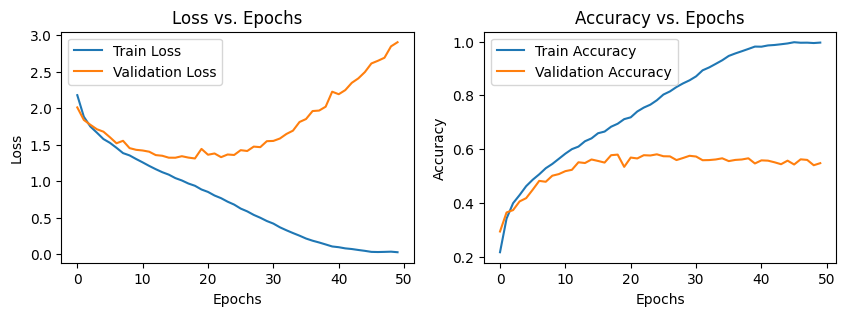

In [79]:
plot_info(train_info)

# Task 5: `test()` Function (8 points)

The last task in most learning tasks is to obtain a final evaluation of a model's performance on test data. Implement the `test()` function below, which takes a (test) dataset and model. It should then perform prediction on each data instance and compute and return the overall accuracy. Its implementation should be relatively similar to that of `train()`.

In [80]:
def test(test_data, model):
    #TODO
    correct = 0
    total = 0
    model.eval()

    with torch.no_grad():
        for inputs, labels in test_data:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy


# Task 6: Model Comparison (8 points)

Let's retrieve the "best" model from the training procedure and compare it against the "last" one that we obtain after 50 epochs. Modify the `train()` from Part 3 to include the following:

* Save the model with the lowest validation loss to ```best_model.pth``` using `torch.save()`. You can do this by comparing each epoch's loss to the lowest one seen so far, and overriding the previous best model with the current one if you see a lower loss.

* Save the model at the end of the training loop to ```last_model.pth```.

After making these additions, instantiate a new model, train it using the same parameters as Task 3, and save your best and last models. Then, evaluate both models on the testing data using your `test()` function. Print the accuracies returned by each.

In [81]:
new_model = CNN(in_channels=3, num_classes=10, device=device)
optimizer = optim.Adam(new_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
train_info = train(train_loader, validation_loader, cnn_model, criterion, optimizer, num_epochs=50)


Epoch 1/50, Train Loss: 0.0203064781166368, Train Acc: 1.00
Epoch 1/50, Val Loss: 2.9042187448133503, Val Acc: 0.55
Epoch 2/50, Train Loss: 0.020245777073381634, Train Acc: 1.00
Epoch 2/50, Val Loss: 2.908844370591013, Val Acc: 0.55
Epoch 3/50, Train Loss: 0.020298248170180607, Train Acc: 1.00
Epoch 3/50, Val Loss: 2.904871820357808, Val Acc: 0.55
Epoch 4/50, Train Loss: 0.02026030546658787, Train Acc: 1.00
Epoch 4/50, Val Loss: 2.905251572006627, Val Acc: 0.55
Epoch 5/50, Train Loss: 0.020243646199161417, Train Acc: 1.00
Epoch 5/50, Val Loss: 2.902282758762962, Val Acc: 0.55
Epoch 6/50, Train Loss: 0.020258650531902452, Train Acc: 1.00
Epoch 6/50, Val Loss: 2.905884723914297, Val Acc: 0.55
Epoch 7/50, Train Loss: 0.020264825873534408, Train Acc: 1.00
Epoch 7/50, Val Loss: 2.903839611170585, Val Acc: 0.55
Epoch 8/50, Train Loss: 0.020299727042009563, Train Acc: 1.00
Epoch 8/50, Val Loss: 2.9040136379108095, Val Acc: 0.55
Epoch 9/50, Train Loss: 0.020248443801201096, Train Acc: 1.00
Epo

In [84]:
best_model = torch.load('/content/drive/MyDrive/best_model.pth')
last_model = torch.load('/content/drive/MyDrive/last_model.pth')
best_accuracy = test(test_loader, best_model)
last_accuracy = test(test_loader, last_model)
print("Best model Accuracy:", best_accuracy)
print("Last model's Accuracy:", last_accuracy)

Best model Accuracy: 0.5454777070063694
Last model's Accuracy: 0.5454777070063694
